In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
%matplotlib inline
import geopandas as gpd
from pandas.core.internals.concat import concat_arrays
from shapely.geometry import Point
import qeds
qeds.themes.mpl_style();
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic
#todos los imports
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


In [2]:
df = pd.read_csv('datos/aguas_subterraneas_2020.csv')
df.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CA�ADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Obtengamos las columnas que tienen valores vacíos y la cantidad de nulos por cada columna

In [4]:
na_columns = df.columns[df.isna().any()].tolist()
na_total = df[na_columns].isna().sum()

pd.DataFrame({'columns': na_columns, 'total': na_total.to_list() })

,columns,total
0,ALC_mg/L,4
1,CALIDAD_ALC,4
2,CONDUCT_mS/cm,6
3,CALIDAD_CONDUC,6
4,SDT_mg/L,1068
5,SDT_M_mg/L,2
6,CALIDAD_SDT_ra,2
7,CALIDAD_SDT_salin,2
8,DUR_mg/L,1
9,CALIDAD_DUR,1


De la tabla anterior se puede apreciar que la columna de Solidos Totales Disueltos (SDT_mg/L) está completamente vacía. La segunda columna con mayor cantidad de nulos es Contaminantes, sin embargo, esta es de esperarse puesto que hay mediciones de agua que no arrojan contaminantes. En otras palabras, un valor nulo en esta columna equivale a ausencia de contaminantes en el agua.

Las demás columnas presentan pocas observaciones nulas. Más adelante definiremos una estrategia para de imputación para estas columnas con valores faltantes.

Del resultado anterior se observa columnas que contienen la misma información pero en tipo de datos diferntes. También hay columnas numéricas detectadas como tipo "object". Vamos a extraer primero todas las columnas categóricas y binarias, ya que son candidatas a ser eliminadas.

In [5]:
#Obtenemos las columnas binarias o categóricas ya que tienen información repetida. Estas son candidatas a eliminarse
cols_to_drop  = df.columns[df.columns.str.contains('CALIDAD|CUMPLE')].to_list()
cols_to_drop


['CALIDAD_ALC',
 'CALIDAD_CONDUC',
 'CALIDAD_SDT_ra',
 'CALIDAD_SDT_salin',
 'CALIDAD_FLUO',
 'CALIDAD_DUR',
 'CALIDAD_COLI_FEC',
 'CALIDAD_N_NO3',
 'CALIDAD_AS',
 'CALIDAD_CD',
 'CALIDAD_CR',
 'CALIDAD_HG',
 'CALIDAD_PB',
 'CALIDAD_MN',
 'CALIDAD_FE',
 'CUMPLE_CON_ALC',
 'CUMPLE_CON_COND',
 'CUMPLE_CON_SDT_ra',
 'CUMPLE_CON_SDT_salin',
 'CUMPLE_CON_FLUO',
 'CUMPLE_CON_DUR',
 'CUMPLE_CON_CF',
 'CUMPLE_CON_NO3',
 'CUMPLE_CON_AS',
 'CUMPLE_CON_CD',
 'CUMPLE_CON_CR',
 'CUMPLE_CON_HG',
 'CUMPLE_CON_PB',
 'CUMPLE_CON_MN',
 'CUMPLE_CON_FE']

Ahora revisemos una de las columnas numéricas que fueron detectadas como object. Tomaremos un ejemplo con Cadmio (CD_TOT_mg/L)

In [6]:
df['CD_TOT_mg/L'].value_counts()

<0.003     1066
0.0056        1
0.03211       1
Name: CD_TOT_mg/L, dtype: int64

De lo anterior se observa que valores muy pequeños son colocados como "<". Para ello, vamos a reemplazar este string por un valor arbitrario por debajo del umbral, de manera que podamos crear una cota inferior y así analizarlo por medio de un histograma o boxplot.

In [7]:
#Definimos las variables numéricas a analizar
vars = [
        'ALC_mg/L','AS_TOT_mg/L', 'CD_TOT_mg/L', 'FE_TOT_mg/L', 'SDT_M_mg/L',
        'SDT_mg/L', 'FLUORUROS_mg/L', 'COLI_FEC_NMP/100_mL', 'CONDUCT_mS/cm', 
        'CR_TOT_mg/L', 'DUR_mg/L', 'HG_TOT_mg/L', 'MN_TOT_mg/L', 'N_NO3_mg/L', 'PB_TOT_mg/L' ]

limits = {}
for  var in vars:
        if  (df[var].dtypes == 'object'):
                #Obtenemos las observaciones que solo tengan < > o =
                limits[var] = df[df[var].str.contains('<|>|=', na='na') == True][var].value_counts().index
#Lo convertimos en DF para mejor visualización
limits_df = pd.DataFrame(limits, index = [0])
display(limits_df.style.hide(axis = 'index'))

AS_TOT_mg/L,CD_TOT_mg/L,FE_TOT_mg/L,SDT_M_mg/L,FLUORUROS_mg/L,COLI_FEC_NMP/100_mL,CR_TOT_mg/L,DUR_mg/L,HG_TOT_mg/L,MN_TOT_mg/L,N_NO3_mg/L,PB_TOT_mg/L
<0.01,<0.003,<0.025,<25,<0.2,<1.1,<0.005,<20,<0.0005,<0.0015,<0.02,<0.005


Se observan que 12 variables tienen valores string. Vamos a proceder sustituir estos strings por valores numéricos.

In [8]:
#Extraemos las columnas que deben ser convertidas de object a float
columns = limits_df.columns

#Hacemos un transpose para que la tabla tenga dos columnas, una con los atributos químicos y otra con sus valores
limits_df = limits_df.transpose()
limits_df = limits_df.reset_index(level = 0)
limits_df.rename(columns={'index': 'attributes', 0:'attr_values'}, inplace= True)

#Extraemos los valores numéricos, eliminando cualquier string (por ej. '<')
limits_df.attr_values = limits_df.attr_values.str.extract('(\d+\.\d+|\d+)')

display(limits_df)
   
   

,attributes,attr_values
0,AS_TOT_mg/L,0.01
1,CD_TOT_mg/L,0.003
2,FE_TOT_mg/L,0.025
3,SDT_M_mg/L,25
4,FLUORUROS_mg/L,0.2
5,COLI_FEC_NMP/100_mL,1.1
6,CR_TOT_mg/L,0.005
7,DUR_mg/L,20
8,HG_TOT_mg/L,0.0005
9,MN_TOT_mg/L,0.0015


In [9]:
#Sustituimos los valores string por un valor float arbitrario, que se encuentre por debajo de lo indicado por la columna
for col in columns:
   val =  (limits_df.loc[limits_df.attributes == col].attr_values.values[0])
   str_match = '<'+ val
   val = float(val)

   df.loc[df[col] == str_match, col] = val -(val/10)
   
   #Convertimos la columna a tipo float
   df[col] = df[col].astype(float)

In [10]:
#Probamos la conversión con una de las columnas
df[['FE_TOT_mg/L']].sort_values(by = 'FE_TOT_mg/L', ascending = False)

,FE_TOT_mg/L
425,178.6150
331,16.4371
9,14.0600
799,13.4400
561,7.3820
...,...
675,0.0225
672,0.0225
671,0.0225
670,0.0225


In [11]:
uniques = {'attributes': [], 'unique_vals': []}
for col in vars:
    uniques['attributes'].append(col) 
    uniques['unique_vals'].append(df[col].unique().size)
    
pd.DataFrame(uniques)

,attributes,unique_vals
0,ALC_mg/L,817
1,AS_TOT_mg/L,209
2,CD_TOT_mg/L,3
3,FE_TOT_mg/L,615
4,SDT_M_mg/L,926
5,SDT_mg/L,1
6,FLUORUROS_mg/L,862
7,COLI_FEC_NMP/100_mL,125
8,CONDUCT_mS/cm,802
9,CR_TOT_mg/L,168


De la tabla anterior, el atributo Solidos Disueltos Totales (SDT_mg/L) está completamente vacío y por eso aparece que tiene solo un valor único. En el caso de Cadmio (CD_TOT), este tiene apenas 3 valores únicos. Revisemos cuáles son estos valores.

In [12]:
df['CD_TOT_mg/L'].value_counts()

0.00270    1066
0.00560       1
0.03211       1
Name: CD_TOT_mg/L, dtype: int64

De lo anterior se puede apreciar que casi el 100% de las observaciones caen dentro del rango aceptable (<0.003), mientras que los otros dos valores no cumplen con el parámetro requerido (>0.005). Esto significa que podríamos perfectamente usar la variable binaria correspondiente a este atributo, ya que la información proporcionada es exactamente la misma.

La columna de Solidos Totales Disueltos se encuentra vacía y por eso aparece con un solo valor único, sin embargo, esta tiene una relación directa con la conductividad del agua, donde puede ser calculada con la siguiente fórmula (https://iwaponline.com/wst/article/77/8/1998/38602/Relationship-between-total-dissolved-solids-and):

TDS (mg/L) = Ke x EC(uS/cm)

donde Ke es un factor que normalmente varía entre 0.55 a 0.85 y EC es la conductividad del agua.

Como la relación de los sólidos totales disueltos es directamente proporcional a la conductividad del agua, esta variable puede ser eliminada para fines de entrenar el modelo, ya que estaría altamente correlacionada con la conductividad, y por ende proporcionar la misma información para el modelo.


A continuación eliminamos dos de las variables numéricas que no usaremos.

In [13]:
#Eliminar Solidos totales disueltos y Cadmio (esta última usaremos mejor la binaria)

Ahora revisemos la correlación entre cada una de las variables del conjunto de datos.

<AxesSubplot:>

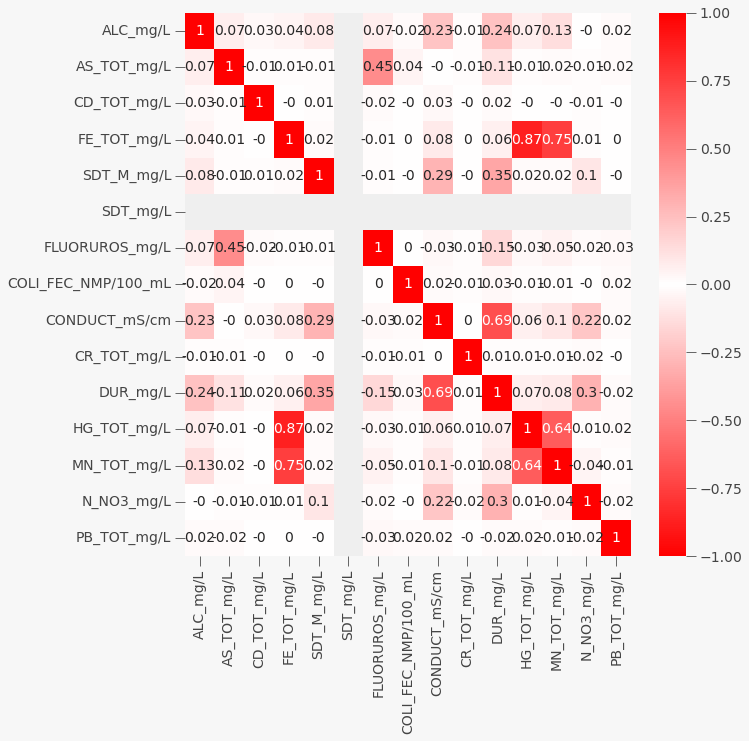

In [14]:
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','red'])
plt.figure(figsize=(10,10))
sns.heatmap(np.round(df[vars].corr(), 2), annot=True, cmap = cmap, vmin = -1.0, vmax = 1.0)

De la tabla anterior se destacan 5 variables que tienen una correlación fuerte:

* Mercurio (HG)
* Manganeso (MN)
* Hierro (FE)
* Conductividad (CONDUCT)
* Dureza (DUR)

Ahora revisemos cuáles de estas variables tienen campos vacíos

In [15]:
df[['HG_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L', 'CONDUCT_mS/cm', 'DUR_mg/L']].isna().any()

HG_TOT_mg/L      False
MN_TOT_mg/L      False
FE_TOT_mg/L      False
CONDUCT_mS/cm     True
DUR_mg/L          True
dtype: bool

In [16]:
df[df['CONDUCT_mS/cm'].isna()][['DUR_mg/L', 'CUMPLE_CON_DUR', 'CUMPLE_CON_COND']]

,DUR_mg/L,CUMPLE_CON_DUR,CUMPLE_CON_COND
18,57.6926,SI,ND
281,45.5170,SI,ND
293,41.5632,SI,ND
616,593.7000,NO,ND
891,383.3319,SI,ND
906,293.0001,SI,ND


In [17]:
df[df['DUR_mg/L'].isna()][['CONDUCT_mS/cm', ]]

,CONDUCT_mS/cm
635,736.0


De lo anterior se visualiza que las variables CONDUCT y DUR tienen campos vacíos, mientras que las demás no. Como su correlación es de cerca 0.7, podríamos utilizar la información de una columna para completar la otra. Pero primero, revisemos que porcentaje de las observaciones coinciden en cumplimiento con los atributos de conductividad y dureza.

In [18]:
#Al existir una alta correlación entre conductividad y dureza, las columnas de cumplimiento coinciden en casi el 85% de las veces. Se podría imputar una de estas columna con el valor correspondiente de la otra
len(df[df['CUMPLE_CON_COND'] == df['CUMPLE_CON_DUR']])/len(df)

0.849250936329588

In [19]:
df['CONTAMINANTES'] = df['CONTAMINANTES'].fillna('SIN_CONTAMINANTE')
df.drop(['SDT_mg/L'], axis=1, inplace=True)
na_columns.remove('SDT_mg/L')


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

catImp_pipeline = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])  

columnasTransformer = ColumnTransformer(transformers = [('catimp', catImp_pipeline, na_columns)],
                                                        remainder='passthrough')
														
									
pipeline = Pipeline(steps=[('ct', columnasTransformer)])

scaled_f = pipeline.fit_transform(df)
scaled_features_df = pd.DataFrame(scaled_f, index=df.index, columns=df.columns)

na_columns = scaled_features_df.columns[scaled_features_df.isna().any()].tolist()
na_total = scaled_features_df[na_columns].isna().sum()

pd.DataFrame({'columns': na_columns, 'total': na_total.to_list() })

,columns,total


In [20]:
df["Coordinates"] = list(zip(df.LONGITUD, df.LATITUD))
df["Coordinates"] = df["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

In [21]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
geo_localizacion = df[['LONGITUD', 'LATITUD']]
kmeans.fit(geo_localizacion)
labels = kmeans.labels_
kmeans = KMeans(n_clusters=4).fit(geo_localizacion)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(geo_localizacion)
C = kmeans.cluster_centers_
df_centers = pd.DataFrame(C)
df_centers["Coordinates"] = list(zip(df_centers[0], df_centers[1]))
df_centers["Coordinates"] = df_centers["Coordinates"].apply(Point)
geo_df = gpd.GeoDataFrame(df_centers, geometry="Coordinates") 

c:\Users\matth\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\matth\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


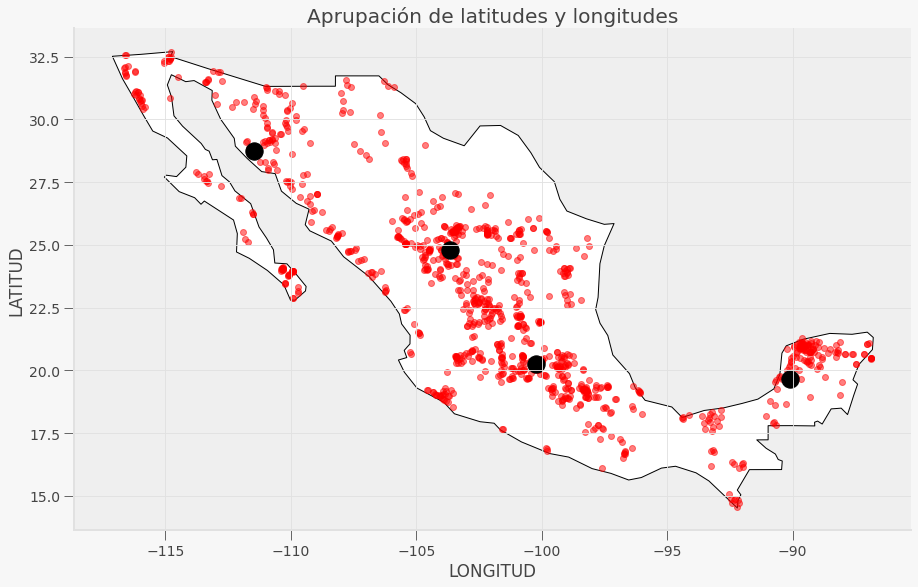

In [22]:
from pandas.core.internals.concat import concat_arrays
coord_1 = str(geo_df[1][0]) + ", " + str(geo_df[0][0])
coord_2 = str(geo_df[1][1]) + ", " + str(geo_df[0][1])
coord_3 = str(geo_df[1][2]) + ", " + str(geo_df[0][2])
fig, gax = plt.subplots(figsize=(15,10))
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')
gdf.plot(ax=gax, color='red', alpha = 0.5)
geo_df.plot(ax=gax, color='black', alpha = 1, markersize = 300)
gax.set_xlabel('LONGITUD')
gax.set_ylabel('LATITUD')
gax.set_title('Aprupación de latitudes y longitudes')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.show()

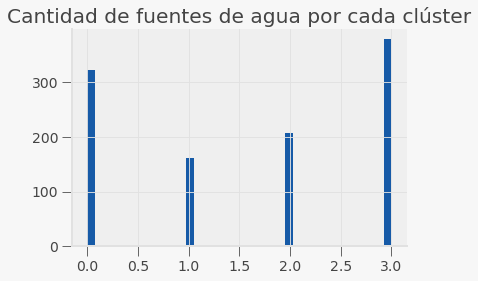

In [23]:
df_describe = pd.DataFrame(labels)
df_describe.describe()
plt.hist(labels, bins=40)  
plt.title('Cantidad de fuentes de agua por cada clúster') 
plt.show()

<AxesSubplot:>

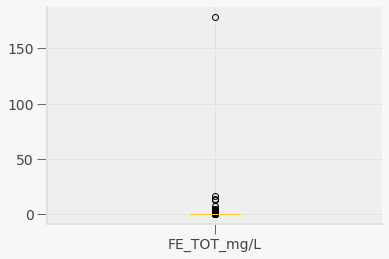

In [24]:
df[['FE_TOT_mg/L']].boxplot()

<AxesSubplot:>

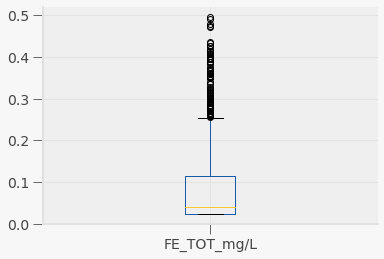

In [25]:
df_test = df.drop(index = df[df['FE_TOT_mg/L'] > 0.5].index)
df_test[['FE_TOT_mg/L']].boxplot()

In [26]:
df[['ALC_mg/L']].value_counts()

ALC_mg/L
157.62      5
257.85      4
168.72      4
197.58      4
161.00      4
           ..
189.72      1
189.81      1
190.05      1
190.06      1
1650.00     1
Length: 816, dtype: int64

<AxesSubplot:>

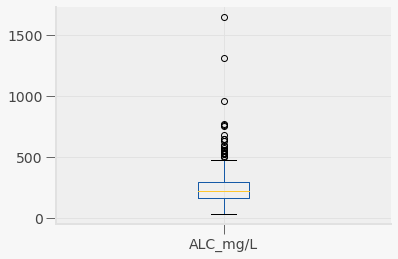

In [27]:
df[['ALC_mg/L']].boxplot()

In [28]:
df[['FLUORUROS_mg/L']].value_counts()

FLUORUROS_mg/L
0.1800            162
0.4660              3
0.5202              3
0.5900              2
0.5620              2
                 ... 
0.4523              1
0.4542              1
0.4570              1
0.4592              1
34.8033             1
Length: 862, dtype: int64

In [29]:
df['CUMPLE_CON_FE'].value_counts()

SI    932
NO    136
Name: CUMPLE_CON_FE, dtype: int64

In [30]:
y = df[['SEMAFORO']]
y.head()

,SEMAFORO
0,Verde
1,Verde
2,Rojo
3,Verde
4,Rojo


In [31]:
(y.value_counts()/len(y)) * 100

SEMAFORO
Verde       40.636704
Rojo        36.235955
Amarillo    23.127341
dtype: float64

In [32]:
columns_to_drop = df.columns[10:41].to_list()
columns_to_drop.append('CONTAMINANTES')
X = df.drop(columns_to_drop, axis = 1)

In [33]:
df.isna().any().sum()

11

In [34]:
df.isna().sum()

CLAVE                   0
SITIO                   0
ORGANISMO_DE_CUENCA     0
ESTADO                  0
MUNICIPIO               0
ACUIFERO                0
SUBTIPO                 0
LONGITUD                0
LATITUD                 0
PERIODO                 0
ALC_mg/L                4
CALIDAD_ALC             4
CONDUCT_mS/cm           6
CALIDAD_CONDUC          6
SDT_M_mg/L              2
CALIDAD_SDT_ra          2
CALIDAD_SDT_salin       2
FLUORUROS_mg/L          0
CALIDAD_FLUO            0
DUR_mg/L                1
CALIDAD_DUR             1
COLI_FEC_NMP/100_mL     0
CALIDAD_COLI_FEC        0
N_NO3_mg/L              1
CALIDAD_N_NO3           1
AS_TOT_mg/L             0
CALIDAD_AS              0
CD_TOT_mg/L             0
CALIDAD_CD              0
CR_TOT_mg/L             0
CALIDAD_CR              0
HG_TOT_mg/L             0
CALIDAD_HG              0
PB_TOT_mg/L             0
CALIDAD_PB              0
MN_TOT_mg/L             0
CALIDAD_MN              0
FE_TOT_mg/L             0
CALIDAD_FE  